### Create the XOR dataset
First, we'll start by creating the classic XOR dataset.

In [2]:
import jax.numpy as jnp
import jax

X = jnp.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = jnp.array([0, 1, 1, 0])[:, None]

Note: its very important to add the "features" column to `Y` (done via `[:, None]`) as code will not complain but the model will not train without it 😅.


### Visualize the dataset
Now we will visualize the dataset simply using `matplotlib` for a sanity check.

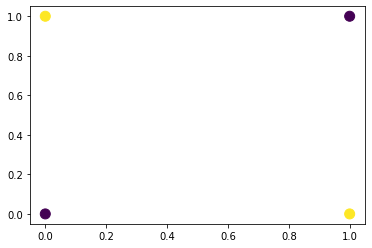

In [3]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=Y, s=100);

### Define an MLP module
The model will be a simple MLP with two layers, as history can remind you the XOR cannot be solved by a single layer. To do this we will just use a `linen.Module` and leverage `nn.compact` to make code simpler.

In [ ]:
import flax.linen as nn

class SimpleMLP(nn.Module):
    units: int
    
    @nn.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        x = nn.Dense(self.units)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

### Create an XOR pytree module

Although its not stricly necesary we will create our own `pytree` module to make the code more readable. This module is somewhat similar to Flax's `TrainState`, we will recreate it for pedagogical purposes. 

In [ ]:
from flax import struct
from flax.core.frozen_dict import FrozenDict
import optax
import typing as tp


@struct.dataclass
class XORModule:
    # nodes
    variables: tp.Optional[FrozenDict]
    opt_state: tp.Optional[optax.OptState]

    # static 
    init_fn: tp.Callable[..., FrozenDict] = struct.field(pytree_node=False)
    apply_fn: tp.Callable[..., jnp.ndarray] = struct.field(pytree_node=False)
    optimizer: optax.GradientTransformation = struct.field(pytree_node=False)

    @classmethod
    def new(cls, model: nn.Module, optimizer: optax.GradientTransformation) -> "XORModule":
        return cls(
            variables=None,
            opt_state=None,
            init_fn=model.init,
            apply_fn=model.apply,
            optimizer=optimizer,
        )

    # this is added automatically by the struct.dataclass decorator
    def replace(self, **kwargs) -> "XORModule":
        ...

Note the following: 

* We have two sets of fields: node fields and statics fields. Static fields are marked by `field(pytree_node=False)`.
* `variables` and `opt_state` are initially set to `None`, they will be created later. 
* We capture the `Module`'s `init` and `apply`, since some modules are not hashable they cannot be static fields.

### Define training loop steps

We will define a couple of function that will be used in the training loop. Ideally these function's would be direct methods on the `XORModule` but this doesn't play well with Jupyter for documentation purposes. Will will directly `jit` some of them for performance. Finally, most of the functions will return a new `XORModule` with the updated by using the `replace` method to create a new instance with updated values.

#### loss_fn
The first one will be the loss function which we will define using Optax's `sigmoid_binary_cross_entropy`.

In [ ]:
def loss_fn(params: FrozenDict, module: XORModule, inputs: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
    assert module.variables is not None
    variables = module.variables.copy({"params": params})

    logits = module.apply_fn(variables, inputs)
    return jnp.mean(optax.sigmoid_binary_cross_entropy(logits, labels))

Note that even though `module` has the `variables` field which already grants access to all the parameters, `loss_fn` receives a separate `params` argument that contains only the parameters that are optimized which we later merge back in via `.copy()`.

#### init_step
Now to initialize the model's parameters we will create an `init_step` function.

In [ ]:
@jax.jit
def init_step(key: jnp.ndarray, module: XORModule, x: jnp.ndarray) -> XORModule:
    variables = module.init_fn(key, x)
    opt_state = module.optimizer.init(variables["params"])

    return module.replace(variables=variables, opt_state=opt_state)

#### train_step
Next, the `train_step` function will just `jax.grad` over `loss_fn` to get the gradients and update the `params` and `opt_state`.

In [ ]:
@jax.jit
def train_step(module: XORModule, inputs: jnp.ndarray, labels: jnp.ndarray) -> XORModule:
    assert module.variables is not None
    assert module.opt_state is not None

    params = module.variables["params"]
    grads = jax.grad(loss_fn)(params, module, inputs, labels)

    updates, opt_state = module.optimizer.update(grads, module.opt_state, params)
    params = optax.apply_updates(params, updates)
    variables = module.variables.copy({"params": params})

    return module.replace(variables=variables, opt_state=opt_state)


#### test_step
The `test_step` fun will simplfy calculate the loss.

In [ ]:
@jax.jit
def test_step(module: XORModule, inputs: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
    assert module.variables is not None
    return loss_fn(module.variables["params"], module, inputs, labels)

#### pred_step
And finally `pred_step` will perform the forward pass and return the predictions.

In [ ]:
@jax.jit
def pred_step(module: XORModule, inputs: jnp.ndarray) -> jnp.ndarray:
    assert module.variables is not None
    return module.apply_fn(module.variables, inputs)

### Training loop
Now we will instantiate the `XORModule` and define the training loop by calling `train_step` and `test_step`. Will will capture the loss every once in a while and plot the learning curve at the end.

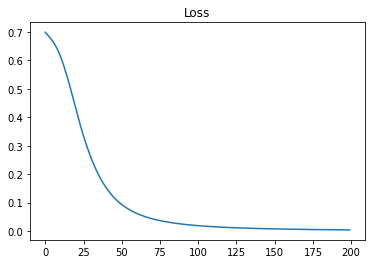

In [ ]:

module = XORModule.new(
    model=SimpleMLP(2), 
    optimizer=optax.adamw(4e-3),
)

key = jax.random.PRNGKey(42)
epochs = 2000
eval_epochs = 10

# initialize
module = init_step(key, module, X)

# training loop
history = []
for epoch in range(epochs):
    # full batch
    module = train_step(module, X, Y)

    if epoch % eval_epochs == 0:
        loss = test_step(module, X, Y)
        history.append(loss)

plt.title("Loss")
plt.plot(history);

### Visualize results

To finish lets visualize the decision boundary by creating a meshgrid, running the prediction an all points using `pred_step`, and creating a `contourf` plot.

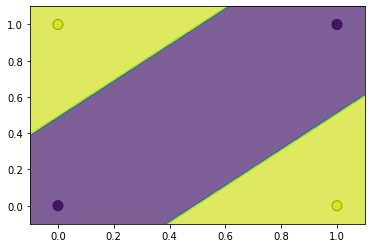

In [ ]:
X0, X1 = jnp.meshgrid(
    jnp.linspace(-0.1, 1.1, 100),
    jnp.linspace(-0.1, 1.1, 100),
)
X01 = jnp.stack([X0, X1], axis=-1)

# get the predictions
preds = pred_step(module, X01)
preds = preds[..., 0] > 0

# plot data
plt.scatter(X[:, 0], X[:, 1], c=Y, s=100, edgecolors='black');
# plot decision boundary
plt.contourf(X0, X1, preds, alpha=0.7);